In [2]:
"""
Script for getting a grip on latent dirichlet allocation

Author: Timo Möller
"""

%matplotlib inline

import numpy as np
import seaborn as sns
import time

from matplotlib import pyplot as plt

In [9]:
def gen_Traindata(num_training,num_words,alpha=0.1,plotting = True):
    """ generate Training data as described in Griffith and Steyvers Paper
    topics generated with size_vocab = 25 (can be reshaped into 5*5 images)
    
    input: num_training...
           num_words (per document)
           alpha determins the spread of topics within each document (bigger values = bigger spread)
           
    return: train[num_training,size_vocab] array of word occurences (BOW)
    """

    #topics are fixed as 5 horizontal and 5 vertical bars in a field 5*5 (size_vocab)
    num_topics = 10
    topics=np.zeros((num_topics,5,5))
    for i in range(5):
        topics[i,i,:]=1.0/5
        topics[i+5,:,i]=1.0/5
    topics = np.reshape(topics,(10,25))  
    
    #generate training examples
    train = np.zeros((num_training,np.shape(topics)[1]))
    #sample topic distribution for each document from dirichlet
    theta = np.random.mtrand.dirichlet([alpha] * num_topics,num_training)
    #for each document                                                               
    for i in range(num_training):
        # sample topic indices for each word according to theta distribution
        z = np.random.multinomial(num_words,theta[i,:]) 
        # sample words from topics
        w=np.zeros(25)
        for j in range(num_topics):
            if z[j] > 0:
                w += np.random.multinomial(z[j],topics[j,:])
        train[i,:]=w

    if plotting:
        plt.figure()
        plt.suptitle('Training documents')
        for i in range(min([8,num_training])):
            plt.subplot(2,4,i)
            plt.imshow(np.reshape(train[i,:],(5,5)),interpolation='nearest')
            plt.axis('off')
        plt.show()
    return train


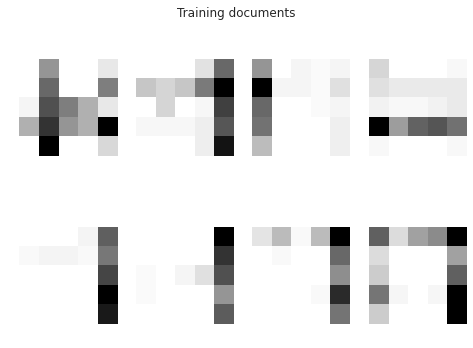

time spent on LDA: 1.46s


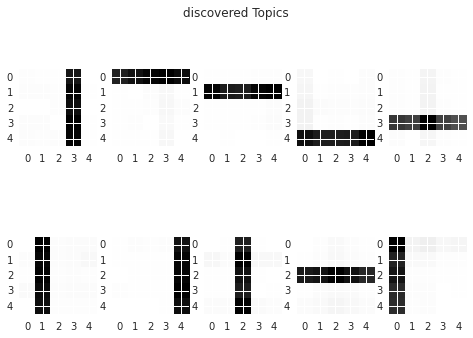

In [12]:
""" quick check if correctly generated training samples
"""
from sklearn.decomposition import LatentDirichletAllocation

train = gen_Traindata(500,100,alpha=0.1,plotting=True)
t0=time.time()
lda = LatentDirichletAllocation(n_topics=10, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)

lda.fit(train)

print 'time spent on LDA: %.2fs' %(time.time() -t0)
plt.figure()
plt.suptitle('discovered Topics')
for i in range(10):
    plt.subplot(2,5,i)
    plt.imshow(np.reshape(lda.components_[i,:],(5,5)),interpolation='nearest')
    #plt.axis('off')

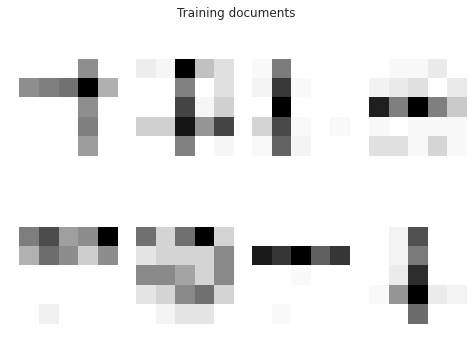

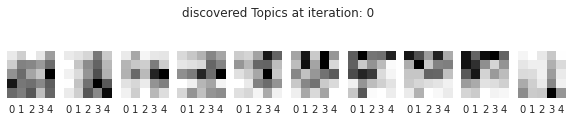

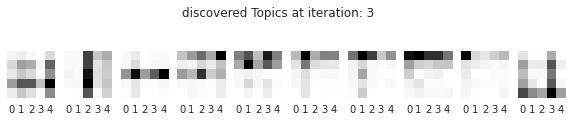

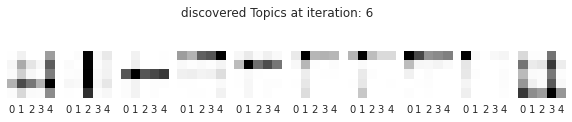

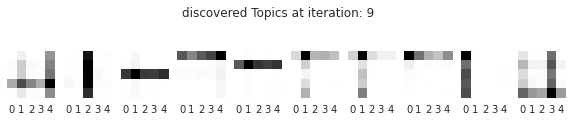

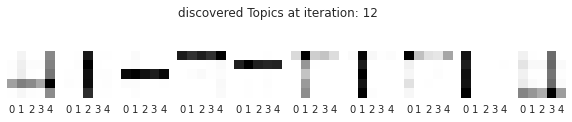

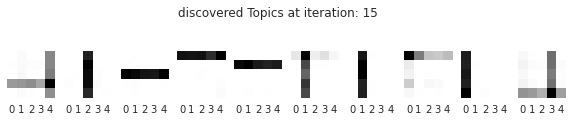

In [21]:
# LDA with Gibbs sampling as described in Yi Wang 2008, "Distributed Gibbs Sampling of Latent Topic
# Models: The Gritty Details" https://cxwangyi.files.wordpress.com/2012/01/llt.pdf
num_doc = 500
train = gen_Traindata(num_doc,num_words=100,alpha=0.1,plotting=True)


#LDA params
k = 10 # num topics
alpha = 0.1
beta = alpha
max_iter = 16


size_vocab = np.shape(train)[1]
#init count vars, Z = k topics, M = num_doc documens, N = size_vocab Words
ZMN = np.zeros((num_doc,size_vocab,k)) # all words to topic assignments
NZM = np.zeros((k,num_doc)) #+ alpha    # document-topic count, alpha & beta added here for faster computation of posterior
NWZ = np.zeros((size_vocab,k)) #+ alpha # topic-term count
NZ  = np.zeros(k) #+ size_vocab * beta  # topic-term sum
for m in range(num_doc):
    for t in range(size_vocab):
        z_idx = np.random.multinomial(train[m,t],[1.0/k]*k)
        ZMN[m,t,:] = z_idx
        NZM[:,m] += z_idx
        NWZ[t,:] += z_idx
        NZ += z_idx

for iteration in range(max_iter):
    #if (np.mod(iteration,5)==0):
        #print 'start iteration:  %i' %iteration
    for m in range(num_doc):
        for t in range(size_vocab):
            """
            Testing for taking away multiple occ of words, because my BOW representation of documents isn't sparse 
            (small vocab size makes sparse rep useless: look at generated docs, every word occurs): 
            
            DOESN'T WORK, learning doesn't converge to input topics. learning doesn't change much of underlying topic distribution anyway.
            
            
            """
            z_idx = ZMN[m,t,:]
            for idx in z_idx.nonzero()[0]:
                for i in range(int(z_idx[idx])):
                    #take away word from counters
                    ZMN[m,t,idx] -= 1
                    NZM[idx,m] -= 1
                    NWZ[t,idx] -= 1
                    NZ[idx] -= 1

                    #sample new topic distribution, pretending all other distributions were correct, EQ: 2.40
                    p_z = (NWZ[t,:] + beta) / (NZ + size_vocab * beta) * (NZM[:,m] + alpha)
                    #p_z = NWZ[t,:] / NZ * NZM[:,m]
                    p_z /= np.sum(p_z) #normalize for probs
                    new_z = np.random.multinomial(1,p_z).argmax()
                    #update count vars
                    ZMN[m,t,new_z] += 1
                    NZM[new_z,m] += 1
                    NWZ[t,new_z] += 1
                    NZ[new_z] += 1

    if (np.mod(iteration,3)==0):
        fig = plt.figure(figsize=(10, 2))
        fig.suptitle('discovered Topics at iteration: %i' %iteration)
        for i in range(10):
            ax = fig.add_subplot(1,10,i)
            num = NWZ + beta
            num /= np.sum(num, axis=0)[np.newaxis,:]
            ax.imshow(np.reshape(num[:,i],(5,5)),interpolation='nearest')   
            ax.get_yaxis().set_ticks([])
            ax.grid(b=False)
        

                    

In [ ]:
""" 
scikit example on 20 newsgroup data to play around
"""
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
print "Loading dataset..."
t0 = time.time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print "done in %0.3fs." % (time.time() - t0)


# Use tf (raw term count) features for LDA.
print "Extracting tf features for LDA..."
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000,stop_words='english')
t0 = time.time()
tf = tf_vectorizer.fit_transform(data_samples)
print "done in %0.3fs." % (time.time() - t0)

# Doing LDA 
num_topics = 20
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=20,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
t0 = time.time()
lda.fit(tf)
print "LDA fitting done in %0.3fs." % (time.time() - t0)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" %(topic_idx+1)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])
    print
    
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words=20)